## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
from IPython.display import display, clear_output
import io


## Load the Saved Model

In [2]:
# Load the saved model
model_ft = tf.keras.models.load_model('../model/model_ft_finetuned.h5')

In [3]:
# Dataset paths
TEST_DIR = '../dataset/test'

In [4]:
BATCH_SIZE = 28
IMG_HEIGHT = 224
IMG_WIDTH = 224

## Data Preprocessing

In [5]:
# Rescaling pixel values to [0, 1] for normalization
dataRescale = ImageDataGenerator(rescale=1./255)

# Creating data generator for test dataset
test_dataset_gen = dataRescale.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 320 images belonging to 8 classes.


## Convert Test Generator to TensorFlow Dataset

In [6]:
# Function to convert a generator to a TFDS
def generator_to_tf_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: (generator[i] for i in range(len(generator))),
        output_types=(tf.float32, tf.float32), 
        output_shapes=(
            (None, IMG_HEIGHT, IMG_WIDTH, 3),
            (None, len(generator.class_indices)) 
        )
    )

# Converting test dataset to TensorFlow dataset
test_dataset = generator_to_tf_dataset(test_dataset_gen)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##  Make Predictions on the Test Dataset

In [7]:
# Evaluate the model on the test dataset
predictions = model_ft.predict(test_dataset, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels from the test dataset
true_classes = np.concatenate([np.argmax(batch[1], axis=1) for batch in test_dataset])

12/12 [==============================] - 10s 221ms/step


## Classification Report

In [8]:
# Generate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=list(test_dataset_gen.class_indices.keys()))
print("\nClassification Report:\n", report)


Classification Report:
                        precision    recall  f1-score   support

    Chest Fly Machine       0.88      0.75      0.81        40
             Dumbbell       0.97      0.95      0.96        40
Lat Pull Down Machine       0.80      0.80      0.80        40
Leg Extension Machine       0.90      0.93      0.91        40
    Leg Press Machine       0.97      0.85      0.91        40
   Seated Row Machine       0.80      0.93      0.86        40
        Smith Machine       0.86      0.95      0.90        40
            Treadmill       0.95      0.97      0.96        40

             accuracy                           0.89       320
            macro avg       0.89      0.89      0.89       320
         weighted avg       0.89      0.89      0.89       320



## Confusion Matrix

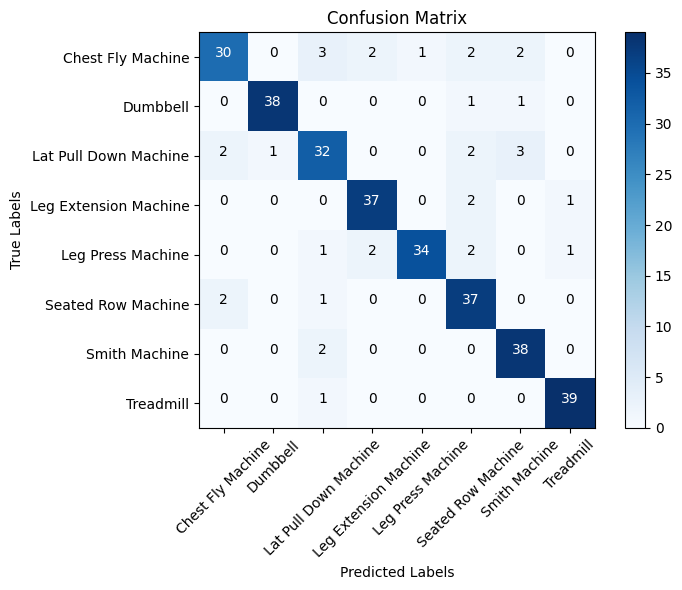

In [9]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix using matplotlib (heatmap)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(test_dataset_gen.class_indices)), list(test_dataset_gen.class_indices.keys()), rotation=45)
plt.yticks(np.arange(len(test_dataset_gen.class_indices)), list(test_dataset_gen.class_indices.keys()))

# Annotate the confusion matrix with the values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

##  Test Performance

In [10]:
# Test performance
test_loss, test_accuracy = model_ft.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 [==============================] - 2s 32ms/step - loss: 0.5097 - accuracy: 0.8906
Test Loss: 0.5096621513366699
Test Accuracy: 0.890625


## Upload Image and Predict Class

### Test Model H5

FileUpload(value=(), accept='image/*', description='Upload')

1/1 [==============================] - 1s 772ms/step


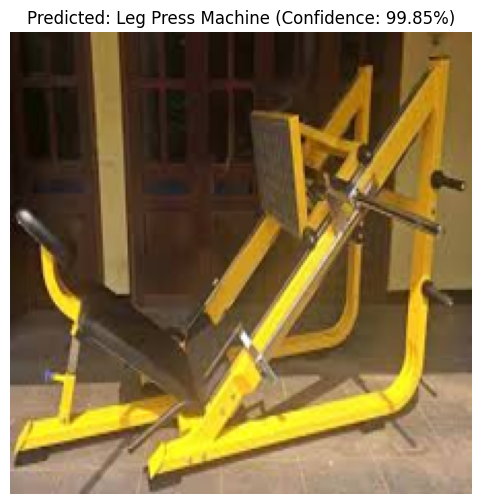

Predicted class: Leg Press Machine
Confidence: 99.85%
1/1 [==============================] - 0s 30ms/step


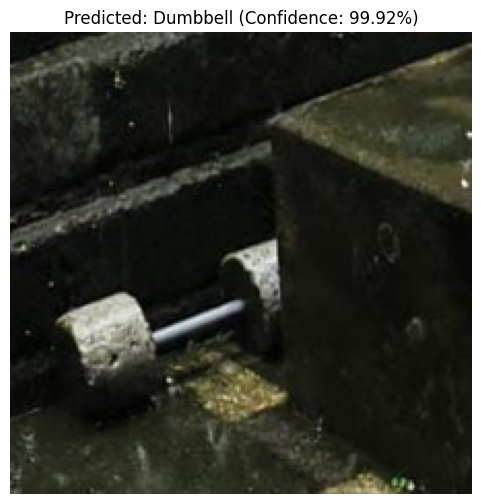

Predicted class: Dumbbell
Confidence: 99.92%
1/1 [==============================] - 0s 31ms/step


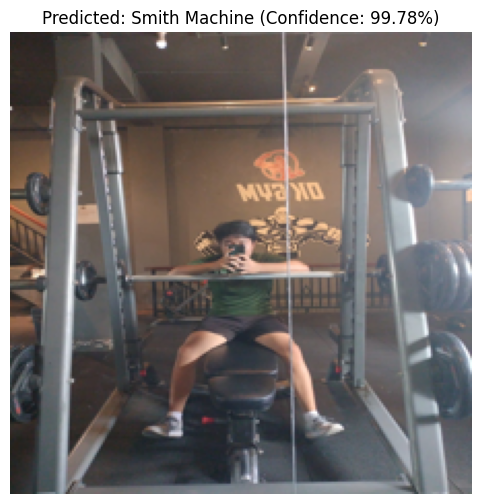

Predicted class: Smith Machine
Confidence: 99.78%


In [11]:
# Function to predict and display the class of an image along with confidence
def predict_image_widget(image_data, model, target_size=(IMG_HEIGHT, IMG_WIDTH), confidence_threshold=0.3):
    # Convert the uploaded image data into a PIL Image
    image = Image.open(io.BytesIO(image_data))
    
    # Resize the image to match the model's input size
    image_resized = image.resize(target_size)
    
    # Convert the image to a numpy array and normalize
    image_array = img_to_array(image_resized) / 255.0
    
    # Add batch dimension (model expects batch input)
    image_array = np.expand_dims(image_array, axis=0)
    
    # Predict the class of the image
    prediction = model.predict(image_array)
    
    # Get the class with the highest probability
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class_index]
    
    # Map the predicted class index to the class label
    class_label = list(test_dataset_gen.class_indices.keys())[predicted_class_index]
    
    # Check if confidence meets the threshold
    if confidence < confidence_threshold:
        class_label = "Posisikan kamera di depan alat dan pastikan alat terlihat jelas."
        confidence = 0  # Optionally set confidence to 0 or some other indication
    
    # Display the image with predicted class and confidence
    plt.figure(figsize=(6, 6))
    plt.imshow(image_resized)
    plt.title(f"Predicted: {class_label} (Confidence: {confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()
    
    # Output predicted class and confidence
    print(f"Predicted class: {class_label}")
    print(f"Confidence: {confidence * 100:.2f}%")

# Create an image upload widget
upload_widget = widgets.FileUpload(
    accept='image/*',  # Allow only image files
    multiple=False  # Single file upload
)

# Callback function to handle image upload
def on_upload_change(change):
    uploaded_files = change['new']
    
    if uploaded_files:
        uploaded_file = uploaded_files[0]
        # Check if the file contains 'content'
        if isinstance(uploaded_file, dict) and 'content' in uploaded_file:
            image_data = uploaded_file['content'].tobytes()  # Convert to bytes
            predict_image_widget(image_data, model_ft)  # Call prediction function with the uploaded image

# Link the upload widget to the callback
upload_widget.observe(on_upload_change, names='value')

# Display the upload widget
display(upload_widget)


### Model TFLite with TFLite Interpreter

FileUpload(value=({'name': 'WhatsApp Image 2024-11-29 at 20.35.43_4891e5fa.jpg', 'type': 'image/jpeg', 'size':…

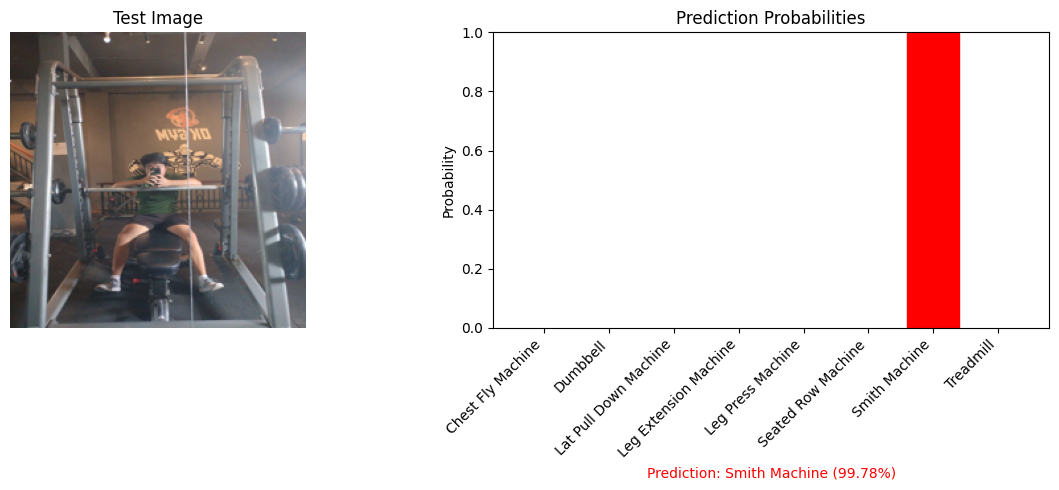

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the TFLite model from the specified path
model_path = "../model/gym_equip_classifier.tflite"
with open(model_path, 'rb') as f:
    tflite_model = f.read()

# Initialize the TFLite interpreter and allocate tensors for inference
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_index = input_details[0]["index"]
output_index = output_details[0]["index"]

# Define the class labels for classification
class_names = [
    "Chest Fly Machine",
    "Dumbbell",
    "Lat Pull Down Machine",
    "Leg Extension Machine",
    "Leg Press Machine",
    "Seated Row Machine",
    "Smith Machine",
    "Treadmill"
]

# Function to load and preprocess an image
def load_and_preprocess_image(image_bytes, target_size=(224, 224)):
    img = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to plot the prediction results
def plot_prediction(image, predicted_label, confidence, class_names, predicted_probabilities):
    plt.figure(figsize=(12, 5))
    # Display the test image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Test Image")

    # Plot the prediction probabilities as a bar chart
    plt.subplot(1, 2, 2)
    bar_plot = plt.bar(range(len(class_names)), predicted_probabilities, color="#777777")
    plt.ylim([0, 1])
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylabel('Probability')
    plt.title("Prediction Probabilities")
    bar_plot[predicted_label].set_color('red')
    plt.xlabel(f"Prediction: {class_names[predicted_label]} ({confidence:.2f}%)", color='red')
    plt.tight_layout()
    plt.show()

# Function to handle file uploads and process the image for prediction
def on_file_upload(change):
    clear_output(wait=True)
    display(uploader)
    uploaded_files = uploader.value
    try:
        if isinstance(uploaded_files, dict):
            for filename, file_info in uploaded_files.items():
                image_bytes = file_info['content']
                processed_image = load_and_preprocess_image(image_bytes, target_size=(224, 224))
                interpreter.set_tensor(input_index, processed_image)
                interpreter.invoke()
                output = interpreter.get_tensor(output_index)
                predicted_probabilities = output[0]
                predicted_label = np.argmax(predicted_probabilities)
                confidence = predicted_probabilities[predicted_label] * 100
                img = Image.open(io.BytesIO(image_bytes)).convert('RGB')
                img = img.resize((224, 224))
                plot_prediction(img, predicted_label, confidence, class_names, predicted_probabilities)
        elif isinstance(uploaded_files, tuple):
            for file_info in uploaded_files:
                if isinstance(file_info, dict):
                    image_bytes = file_info['content']
                    processed_image = load_and_preprocess_image(image_bytes, target_size=(224, 224))
                    interpreter.set_tensor(input_index, processed_image)
                    interpreter.invoke()
                    output = interpreter.get_tensor(output_index)
                    predicted_probabilities = output[0]
                    predicted_label = np.argmax(predicted_probabilities)
                    confidence = predicted_probabilities[predicted_label] * 100
                    img = Image.open(io.BytesIO(image_bytes)).convert('RGB')
                    img = img.resize((224, 224))
                    plot_prediction(img, predicted_label, confidence, class_names, predicted_probabilities)
        else:
            print(f"Unknown type of uploader.value: {type(uploaded_files)}")
    except AttributeError as e:
        print(f"AttributeError occurred: {e}")
    except Exception as e:
        print(f"An error occurred while processing the upload: {e}")

# Set up the file uploader widget and attach the callback function
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False
)
uploader.observe(on_file_upload, names='value')
display(uploader)